# NADPH experiments with whole Prx system

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Analysis: simulations of NADPH reduction assays in a system containing Prx, Trx, TRR, and $H_2O_2$

Plot: Figure 7c and 7d

**Requirements:**

Python libraries (see **Imports** below)

Prx parameters (filename:`fitted_koff_kon_PRDX1_params.csv`)

Prx PRDX2 system model (filename: `PRDX2_sys.psc`)

Prx PRDX2 system model with decamer reactions (filename: `PRDX2_sys_decfull.psc`)

##### Imports

In [1]:
import os
import copy

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.linear_model import LinearRegression

import pysces


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

###### Save directories

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


###### Matplotlib stuff

In [3]:
%matplotlib inline

mpl_width = 4.5
mpl_height = 3.5
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"


In [4]:
# Marker symbols
WSA_no_dec_marker = "^"
WSA_dec_marker = "s"
# WSA_dec_dil = "o"
mpl_marker_size = 6

In [5]:
color_wheel = ["tab:blue","tab:green","tab:red","tab:cyan","tab:purple"]

##### fitted params

In [6]:
fitted_dim_dec_rates_file = "fitted_koff_kon_PRDX1_params.csv"
df_dim_dec_rates = pd.read_csv(os.path.join(par_dir,fitted_dim_dec_rates_file))
df_dim_dec_rates.set_index("Parameter",inplace=True)

In [7]:
def update_params_BenfeitasModels(mod,params,hyp=False):
    """
    Updates the parameters of a model which has been augmented with Prx decamer reactions.
    Adding the decamer reactions introduces several new parameter names which need to be populated with their 
    corrosponding values in the original model as well as the fitted dimer-decamer transition koff and kon.
    As a special case: The decamer sulfenilation rate is set to the original model dimer sulfenilation rate 
    (i.e full activity) and the dimer sulfenilation rate is set to 100-fold less than the original model.
    """
    # Dimer-decamer transition params
    mod.exponent = 5
    mod.k_Prx_asso = params.loc["kon"][0]
    mod.k_Prx_dec_disasso = params.loc["koff"][0]
    
    ## Prx oxidation params
    mod.k_Prx_sulfe_SH_dec = mod.kprx
    mod.k_Prx_sulfe_SOH_dec = mod.kprx
    mod.k_Prx_disulf_form_SH_dec = mod.kcond
    mod.k_Prx_disulf_form_SOH_dec = mod.kcond
    mod.k_Prx_disso_SH_dec = 10000 # Arbitrary 
    mod.k_Prx_disso_SOH_dec = 10000 # Arbitrary
    
    if hyp == True:
        mod.k_Prx_sulfe_SOOH_dec = mod.kprx
        mod.k_Prx_sulfi_SOOH_dec = mod.ksulf
        mod.k_Prx_disulf_form_SOOH_dec = mod.kcond
        mod.k_Prx_srx_SOOH_dec = mod.ksrx 
        mod.k_Prx_disso_SOOH_dec = 10000 # Arbitrary
        
    # Adust dimer sulfenilation to be 100 slower than decamer
    mod.kprx = mod.kprx/100
#     mod.two_times_kprx = mod.two_times_kprx/100
    
    return mod


## NADPH assay functions

In [8]:
def do_NADPH_exp_double_vary(mod,
                             vary,
                             vary_init_range,
                             vary2,
                             vary2_init,
                             assay_end=1000, # time in s
                             assay_points=1000,
                             i_rate_start=3, # data point idx
                             i_rate_end=10): # data point idx
    """
    Performs an NADPH experiment varying two parameters to get the rate constant vs second parameter.
    """
    # Update model with new second param
    vary2_orig = getattr(mod,vary2)
    setattr(mod,vary2,vary2_init)
    
    # Simulate NADPH initial rates experiment
    NADPH_exp = do_NADPH_exp(mod,
                             vary,
                             vary_init_range,
                             assay_end=assay_end,
                             i_rate_start=i_rate_start,
                             i_rate_end=i_rate_end)
    
    # Restore model
    setattr(mod,vary2,vary2_orig)
    
    # Grab data
    rate_constant = (vary2_init,NADPH_exp[3])
    
    return rate_constant

def do_NADPH_exp(mod,
                 vary,
                 vary_init_range,
                 assay_end=600, # time in s
                 assay_points=1000,
                 i_rate_start=3, # data point idx
                 i_rate_end=10): # data point idx
    """
    Performs an NADPH experiment of several assay runs.
    Fits initial rates on each run.
    Determines the rate constant.
    """
    
    # Do assay runs
    traces = list(map(lambda vary_init: do_NADPH_assay(mod, 
                                                       vary,
                                                       vary_init,
                                                       end_time=assay_end,
                                                      points=assay_points), 
                      vary_init_range))
    
    # Fit initial rates of assays
    start_point = 3
    end_point = 10
    initial_rates = fit_initial_rates(traces,vary_init_range,i_rate_start,i_rate_end)
    
    # Fit rate constant to initial rates
    initial_rate_lm = LinearRegression().fit(initial_rates[:,0].reshape(-1,1), 
                                       np.abs(initial_rates[:,1]).reshape(-1,1))
    
    rate_constant = initial_rate_lm.coef_[0][0]
    
    return (traces,initial_rates,initial_rate_lm,rate_constant)

def do_NADPH_assay(mod,
                   vary,
                    vary_init,
                    end_time=15,
                    points=1000):
    """
    Performs an NADPH assay time course assay using a model containing H2O2 and NADPH.
    """
    # Update model with assay params
    vary_orig = getattr(mod,vary)
    setattr(mod,vary,vary_init)    

    # Get equilibrium at H2O2_init = 0
    H2O2_orig = getattr(mod,"H2O2_init")
    setattr(mod,"H2O2_init",0.0)
    mod.doSim(end=1000000,points=2)

    # Update model with equilibrium species concentrations
    for species in mod.species:
        setattr(mod, f"{species}_init",mod.sim[species][-1])
        
    # Restore H2O2_init
    if vary == "H2O2_init":
        setattr(mod,"H2O2_init",vary_init)
    else:
        setattr(mod,"H2O2_init",H2O2_orig)

    # Simulate
    mod.sim_end = end_time
    mod.sim_points = points
    mod.Simulate()

    # Grab data
    result = np.array((mod.sim["Time"],mod.sim["NADPH"]))

    # Restore model
    setattr(mod,vary,vary_orig)
        
    return result

def fit_initial_rates(data,vary_init_range,start_point,end_point):
    """
    Fits the initial rates of an NADPH assay
    """
    initial_rates = list(map(lambda data_trace: get_initial_rate(data_trace,start_point,end_point,), data))
    
    initial_rate_data = np.array((vary_init_range,initial_rates)).transpose()
    
    return initial_rate_data

def get_initial_rate(trace_data,start_point,end_point):
    """
    Gets the initial rate of a time course.
    """
    x_initial = trace_data[0][start_point:end_point].reshape(-1,1)
    y_initial = trace_data[1][start_point:end_point].reshape(-1,1)
    model = LinearRegression().fit(x_initial, y_initial)
    r_sq = model.score(x_initial, y_initial)
    if r_sq < 0.95:
        print(f"WARNING, non-linear data range:\n r_sq = {r_sq:.4}")
    return model.coef_[0][0]



## NADPH assay (figure 7c and 7d)

Assay species concentrations based thesis: Investigating the dynamics of hydrogenperoxide metabolism in the peroxiredoxinsystem of Saccharomyces cerevisiae fig 4.14 

In [9]:
# Set assay conditions
exp_Prx_p1 = 0.05 # µM
exp_Trx_p1 = 10 # µM
kcatTRR = 73
exp_TRR_p1 = 0.5 # µM
exp_H2O2_p1 = 5 # H2O2 0 to 10 µM
exp_NADPH_p1 = 150 # µM
# ammonium sulfate, 100 mM; EDTA, 1 mM; potassium phosphate, 25 mM 
# (pH 7)

In [10]:
# Load models

# Prx cycle with decamers
mod_Prx_cycle_no_dec_p1 = pysces.model("PRDX2_sys.psc", dir=mod_dir)
mod_Prx_cycle_no_dec_p1.mode_integrator = 'CVODE'

# Prx cycle with decamers
mod_Prx_cycle_with_dec_p1 = pysces.model("PRDX2_sys_decfull.psc", dir=mod_dir)
mod_Prx_cycle_with_dec_p1.mode_integrator = 'CVODE'
mod_Prx_cycle_with_dec_p1 = update_params_BenfeitasModels(mod_Prx_cycle_with_dec_p1,df_dim_dec_rates)

# Adjust Prx cycle no decamer
setattr(mod_Prx_cycle_no_dec_p1, "SH_SH_init", exp_Prx_p1)
setattr(mod_Prx_cycle_no_dec_p1, "TrxSH_init", exp_Trx_p1*5) # 5x so that reduction is not rate limiting.
setattr(mod_Prx_cycle_no_dec_p1, "VMaxTrxR", exp_TRR_p1*kcatTRR)
setattr(mod_Prx_cycle_no_dec_p1, "H2O2_init", exp_H2O2_p1)
setattr(mod_Prx_cycle_no_dec_p1, "NADPH_init", exp_NADPH_p1)

# Adjust Prx cycle with decamer
setattr(mod_Prx_cycle_with_dec_p1, "SH_SH_init", exp_Prx_p1)
setattr(mod_Prx_cycle_with_dec_p1, "TrxSH_init", exp_Trx_p1*5) # 5x so that reduction is not rate limiting.
setattr(mod_Prx_cycle_with_dec_p1, "VMaxTrxR", exp_TRR_p1*kcatTRR)
setattr(mod_Prx_cycle_with_dec_p1, "H2O2_init", exp_H2O2_p1)
setattr(mod_Prx_cycle_with_dec_p1, "NADPH_init", exp_NADPH_p1)



Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . .  done.
 
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/PRDX2_sys_decfull.psc
Info: No reagents have been fixed
 
Calculating L matrix . . . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . .

In [11]:
# Assay params
vary_vp = "SH_SH_init"
vary_init_range_vp_p1 = np.array([0.01,0.05,0.1])

In [12]:
# Simulate NADPH initial rates experiments
vary_vp = "SH_SH_init"
vary_init_range_vp_p1 = np.array([0.01,0.05,0.1])
assay_end=300
assay_points=assay_end+1
i_rate_start=3
i_rate_end=10

mod = mod_Prx_cycle_no_dec_p1
NADPH_exp_no_dec_p1_vp = do_NADPH_exp(mod,
                                 vary_vp,
                                 vary_init_range_vp_p1,
                                 assay_end=assay_end,
                                 i_rate_start=i_rate_start,
                                 i_rate_end=i_rate_end)

mod = mod_Prx_cycle_with_dec_p1
NADPH_exp_with_dec_p1_vp = do_NADPH_exp(mod,
                                 vary_vp,
                                 vary_init_range_vp_p1,
                                 assay_end=assay_end,
                                 i_rate_start=i_rate_start,
                                 i_rate_end=i_rate_end)


CVODE time for 2 points: 0.0012810230255126953
CVODE time for 1000 points: 0.07147669792175293
CVODE time for 2 points: 0.0012531280517578125
CVODE time for 1000 points: 0.10266923904418945
CVODE time for 2 points: 0.0022003650665283203
CVODE time for 1000 points: 0.09808826446533203
CVODE time for 2 points: 0.07253623008728027
CVODE time for 1000 points: 0.7211570739746094
CVODE time for 2 points: 0.12471437454223633
CVODE time for 1000 points: 1.0938663482666016
CVODE time for 2 points: 0.1556391716003418
CVODE time for 1000 points: 1.4076013565063477


/tmp/ipykernel_9807/3841212152.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


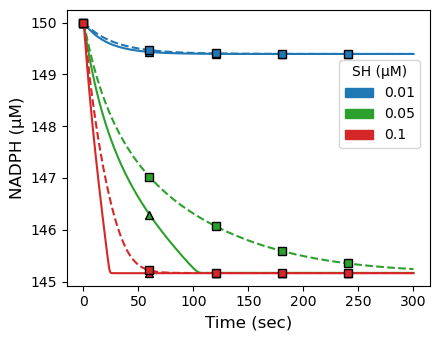

In [13]:
# Plot time courses

# Assay data for plot
NADPH_assays_no_dec = NADPH_exp_no_dec_p1_vp[0]
NADPH_assays_with_dec = NADPH_exp_with_dec_p1_vp[0]

# Build figure
cols = 1
rows = 1

f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width,h=mpl_height)

handle_list= []

for count,assay in enumerate(NADPH_assays_no_dec):
    axarr.plot(assay[0,:], 
               assay[1,:], 
               f"{color_wheel[count]}",
               marker=WSA_no_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k') 
    handle = mpatches.Patch(color=f"{color_wheel[count]}", label=f"{vary_init_range_vp_p1[count]}")
    handle_list.append(handle)
    
for count,assay in enumerate(NADPH_assays_with_dec):
    axarr.plot(assay[0,:], 
               assay[1,:], 
               f"{color_wheel[count]}",
               linestyle="--",
               marker=WSA_dec_marker,
               markevery=200,
               markersize = mpl_marker_size,
               mec = 'k')
    
axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel(f"NADPH ({mu}M)",fontsize=mpl_ylabel_fontsize)

title_species = vary_vp.split("_")[0]
axarr.legend(handles=handle_list,title=f"{title_species} ({mu}M)",loc=(0.75,0.5))
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir, "nadph_NADPH_v_time_vary_Prx.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_9807/3244654116.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


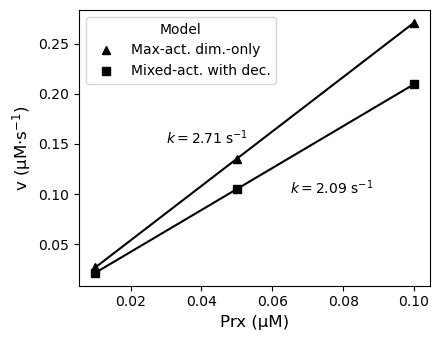

In [14]:
# Plot initial rates

# Assign data
NADPH_exp_no_dec = NADPH_exp_no_dec_p1_vp 
NADPH_exp_with_dec = NADPH_exp_with_dec_p1_vp

i_rates_no_dec = NADPH_exp_no_dec[1]
ir_lm_no_dec = NADPH_exp_no_dec[2]
k_no_dec = NADPH_exp_no_dec[3]

i_rates_with_dec = NADPH_exp_with_dec[1]
ir_lm_with_dec = NADPH_exp_with_dec[2]
k_with_dec = NADPH_exp_with_dec[3]

# Build figure
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

axarr.plot(i_rates_no_dec[:,0],
           np.abs(i_rates_no_dec[:,1]),
           color=f"k",
           label="Max-act. dim.-only",
           marker=WSA_no_dec_marker,
           markersize = mpl_marker_size,
           linestyle="None")
axarr.plot(vary_init_range_vp_p1, 
           ir_lm_no_dec.predict(vary_init_range_vp_p1.reshape(-1,1)),
           f"k-")
axarr.text(0.03,0.15,f"$k={k_no_dec:.3}\ \mathrm{{s^{{-1}}}}$")

axarr.plot(i_rates_with_dec[:,0],
           np.abs(i_rates_with_dec[:,1]),
           color=f"k",
           label=f"Mixed-act. with dec.",
           marker=WSA_dec_marker,
           markersize = mpl_marker_size,
          linestyle="None")
axarr.plot(vary_init_range_vp_p1, 
           ir_lm_with_dec.predict(vary_init_range_vp_p1.reshape(-1,1)),
           f"k-")
axarr.text(0.065,0.1,f"$k={k_with_dec:.3}\ \mathrm{{s^{{-1}}}}$")

axarr.set_xlabel(f"Prx ({mu}M)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel(f"v ({mu}M$\cdot \mathrm{{s^{{-1}}}}$)",fontsize=mpl_ylabel_fontsize)

axarr.legend(title = f"Model")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir, "nadph_Prx_v_rate.pdf"),dpi= mpl_dpi)